CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torchvision.datasets import CIFAR10
import numpy as np
import scipy.stats as stats
import math
import random

SEED = 0
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_eval_dataset = CIFAR10(root='./data/cifar10', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data/cifar10', train=False, download=True, transform=transform)

/home/kevinkuo/miniconda3/envs/fedhp/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified
Files already downloaded and verified


In [2]:
num_classes = 10
ex_per_class = len(train_eval_dataset) // num_classes
sorted_data = sorted(train_eval_dataset, key=lambda x: x[1]) # sort by label
labels = [i for _, i in sorted_data]
label_idx = [labels.index(i) for i in range(10)]

# hold out 1000 from each class
np.random.seed(SEED)
num_eval = ex_per_class // 5
eval_idx = np.concatenate([min_idx + np.random.choice(ex_per_class, num_eval, replace=False) for min_idx in label_idx])
eval_dataset = torch.utils.data.Subset(sorted_data, eval_idx)
train_idx = np.delete(np.arange(50000), eval_idx)
train_dataset = torch.utils.data.Subset(sorted_data, train_idx)

In [5]:
np.random.seed(SEED)
ALPHA = 0.1
alpha = np.repeat(ALPHA, num_classes)
rv_tr = stats.dirichlet.rvs(alpha, size=400, random_state=SEED) 
rv_tr = rv_tr / rv_tr.sum(axis=0)
rv_ts = stats.dirichlet.rvs(alpha, size=100, random_state=SEED) 
rv_ts = rv_ts / rv_ts.sum(axis=0)

In [10]:
def split_data(dataset, client_idxs, rv):
    split_total = []
    for r in rv[client_idxs]:
        split = [round(p*(len(dataset)//num_classes)) for p in r]
        split_total.append(split)
    split_total = np.array(split_total)
    # split_total[client_idx][label_idx] = label_freq

    print("Num of examples per user, mean/std", split_total.sum(axis=1).mean(), split_total.sum(axis=1).std())

    sorted_data = sorted(dataset, key=lambda x: x[1]) # sort by label
    cs_split = np.cumsum(split_total, axis=0)
    labels = [i for _, i in sorted_data]
    label_idx = [labels.index(i) for i in range(10)]
    max_ex = len(dataset) // num_classes
    cs_split[cs_split > max_ex] = max_ex
    cs_split[-1] = max_ex # sets whole row

    # iter over clients
    split_dataset = []
    for row, (split, cumsum) in enumerate(zip(split_total, cs_split)):
        user = []
        # iter over labels
        for col, (num, cs) in enumerate(zip(split, cumsum)):
            if num == 0: continue
            start = label_idx[col] + cs - num
            end = label_idx[col] + cs
            # while end < len(labels) and labels[end] != col:
            #     end -= 1
            user.extend(range(start, end))
        split_dataset.append(user)
    
    tasks = []
    for u in split_dataset:
        task = list(zip(*(sorted_data[i] for i in u)))
        tasks.append(task)
    return tasks

In [11]:
train_split = split_data(train_dataset, range(0,400), rv_tr) # 80/20 train clients
eval_split = split_data(eval_dataset, range(0,100), rv_ts) # 100 (10k) eval client

Num of examples per user, mean/std 99.83 8.701212559178174
Num of examples per user, mean/std 99.96 12.56496717066941


(array([ 1.,  0.,  0., 92.,  0.,  8.,  0.,  0.,  0.,  9.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <BarContainer object of 10 artists>)

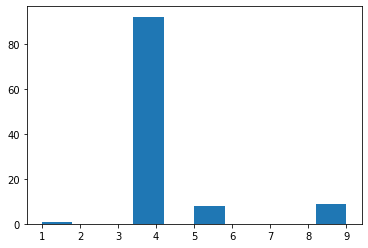

In [34]:
import matplotlib.pyplot as plt
plt.hist(train_split[0][1]) # labels of client 0

FEMNIST

In [ ]:
# git clone https://github.com/TalwalkarLab/leaf
# cd leaf/data/femnist
# ./preprocess.sh -s niid --sf 1.0 -k 1 -t user --tf 0.9

In [26]:
import json
with open("/home/kevinkuo/leaf/data/femnist/data/test/all_data_0_niid_1_keep_1_test_9.json") as f:
    data = json.load(f)

In [41]:
user = data['users'][0]
user

'f2530_91'

In [45]:
task = data['user_data'][user]
x, y = task['x'], task['y']

(array([90., 41., 10.,  3.,  6.,  8.,  7.,  7.,  6.,  6.]),
 array([ 0. ,  6.1, 12.2, 18.3, 24.4, 30.5, 36.6, 42.7, 48.8, 54.9, 61. ]),
 <BarContainer object of 10 artists>)

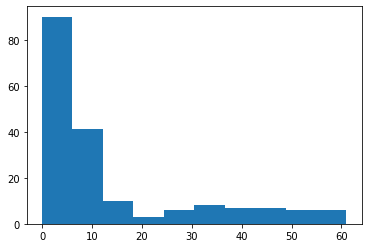

In [47]:
plt.hist(y)